# NN Project, topic #4: Language identification from a text corpus

Students: Shahzaib MUHAMMAD, Adriana NICOARA, Scott TANKARD

## Our group's topic

From: https://arche.univ-lorraine.fr/mod/page/view.php?id=1310565

Project 4: Language identification from a text corpus

Students: Scott TANKARD, Adriana NICOARA, Shahzaib MUHAMMAD

Task: Text classification

Model: Feedforward neural network

Dataset: https://www.kaggle.com/zarajamshaid/language-identification-datasst

Hint: As a preprocessing step, you should transforms the sentences into trigrams at the character level (more details at: https://towardsdatascience.com/deep-neural-network-language-identification-ae1c158f6a7d)

## General project instructions

From: https://arche.univ-lorraine.fr/mod/page/view.php?id=1301340

General project instructions

Project structure

Each project follows the same overall structure:

    Download the data and preprocess it as required for the given task (if needed).
    
    Write a Dataset class for creating the train and test datasets (and corresponding dataloaders).
    
    Define the neural network model.
    
    Define the hyperparameters to create an instance of the model (e.g., hidden space size, number of convolution kernels...) as well as the parameters required to train neural network (e.g., learning rate).
    
    Write the training loop for training the model.
    
    Evaluate the model on the test data. In this part, it is expected to choose an appropriate evaluation metric based on your task. For instance, for classification task, accuracy should be computed (but you can also search for 'precision' and 'recall').
    
    Save the trained model parameters, and the obtained results if needed.


Deliverables

The project should be written using Pytorch (and not Keras/Tensorflow or any other python deep learning framework). You're expected to send a zip file containing:

    A python file implementing steps 1 to 7. This can be either a jupyter notebook or a .py script. A single file is preferred, but you can use several files if that's your style, as long as your main executable script is clearly indicated (for instance it's named 'main.py').
    
    The obtained results as extra files (e.g., the trained model parameters, a figure with the training loss / validation metric over epochs, a graph comparing different architectures if you want to play arround with it, etc.)

Your code should be commented in order to clarify implementation details, and desciption about the inputs and outputs of functions.

Note: There is no need to send the dataset, since I will download it and run your scripts directly. Therefore, make sure that you do not transform/change the raw data, and if there is some preprocessing involved, include it in your python file(s).


General Hints

    The tasks corresponding to these projects have been extensively studied. Don't hesitate to search online for more information (either tutorials or research papers, even pieces of code if you can adapt it).
    
    Some datasets are very large. Therefore, you don't need to use all the data, but instead you can extract a subset of it (for instance, only a few languages for language identification, only a few images/classes for image recognition etc.) to have a lighter dataset / model / training procedure.
    
    Some datasets are provided with a train / test split, but not always. Either way, you can create your own split (a good rule of thumb can be 80% training and 20 % testing).
    
    It is strongly advised to use validation in order to monitor training (see 'bonus work' in lab 2.2). You can use part of the training data (e.g., 10%) as a validation set.
    
    It is good practice to start with a light model (very few layers/parameters) and dataset (subset of your whole dataset) for prototyping. The performance won't be very good, but it's useful to check if there are any error in the train/test procedure. Once everything runs smoothly, you can increase the size of the model and use more data.
    
    If your project includes convolutional or recurrent neural networks, don't wait the corresponding lab: you can already start working on it (you can basically do everything, just using a 'dummy' MLP model instead of a CNN/RNN).

Modifié le: vendredi 21 octobre 2022, 12:46

In [ ]:
import os
import random

import torch

# import torchvision
import torch.nn as nn

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split, Subset

# from skimage import io, transform
#from torch.utils.data import DataLoader, random_split, Subset
import copy


In [ ]:
# CONSTANTS:
filterLanguage = True  # Either Filter the dataset or not.

LANG_FILTER_LIST = [
        "Estonian",
        "Swedish",
        "Indonesian",
        "Turkish",
        "French",
        "Romanian",
        "English",
]

In [ ]:
# STEP 1: Download the data and preprocess it as required for the given task (if needed).
#########

In [ ]:
data = pd.read_csv("./dataset.csv")
data.info()

In [ ]:
data.head(10)

In [ ]:
unique_lang = data["language"].unique()
print(unique_lang)
print("Number of unique languages: ", len(unique_lang))

We choose 7 languages to work with:

In [ ]:
print(f'{data.shape=}')

In [ ]:
data_trim = pd.DataFrame(columns=["Text", "language"])
lang = None
if filterLanguage:
    lang = LANG_FILTER_LIST
    data_trim = pd.DataFrame(columns=["Text", "language"])
    for l in lang:
        lang_trim = data[data["language"] == l].sample(1000, random_state=100)
        data_trim = data_trim.append(lang_trim)

else:
    lang = data["language"].unique()
    data_trim = data

print(f'{data_trim.shape=}')

In [ ]:
# We will need this later for output_size
global num_languages
num_languages = len(lang)
print(num_languages)

In [ ]:
# STEP 1B: Write a Dataset class for creating the train and test datasets.
#########

In [ ]:
def reset_indexes(dataframes: list):
    """Shorthand which allows to reset indexes for multiple Pandas dataframes like so:
    reset_indexes([X_train, X_test, y_train, y_test])"""
    for df in dataframes:
        df.reset_index(drop=True, inplace=True)

In [ ]:
def get_trigrams(corpus, n_feat=200):
    """
    Returns a list of the N most common character trigrams from a list of sentences
    params
    ------------
        corpus: list of strings
        n_feat: integer
    """
    # fit the n-gram model
    vectorizer = CountVectorizer(
        analyzer="char_wb", ngram_range=(3, 3), max_features=n_feat
    )

    X = vectorizer.fit_transform(corpus)

    # Get model feature names
    feature_names = vectorizer.get_feature_names()
    return feature_names

In [ ]:
X = data_trim["Text"]
y = data_trim["language"]

#encoded labels
le = preprocessing.LabelEncoder()

labels = list(y)
le.fit(labels)


#train test val split 80% 10% 10%
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y,
)

reset_indexes([X_train, X_test, y_train, y_test])

X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=0.50, random_state=42, stratify= y_test,
)

reset_indexes([X_val, X_test, y_val, y_test])

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
val_data = pd.concat([X_val, y_val], axis=1)

In [ ]:
# keeping most frequent trigrams (200 by default)

features = {} # used to calculate overlapping trigrams
features_set = set()

for l in lang:
    # get corpus filtered by language
    corpus = train_data[train_data.language == l]["Text"]
    # get 200 most frequent trigrams
    trigrams = get_trigrams(corpus)

    # add to dict and set
    features[l] = trigrams
    features_set.update(trigrams)

# create vocabulary list using feature set
vocab = dict()
for i, f in enumerate(features_set):
    vocab[f] = i


# We will need this later for input_size
global num_trigram_features
num_trigram_features = len(vocab)
print(f'{num_trigram_features=}')

In [ ]:
def vectorize_data(dataset, vectorizer):
    # create feature matrix for training set
    X_vectorized = vectorizer.transform(dataset)
    feature_names = vectorizer.get_feature_names()
    features = pd.DataFrame(data=X_vectorized.toarray(), columns=feature_names)
    return features, feature_names

In [203]:
# train count vectoriser using vocabulary
vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(3, 3), vocabulary=vocab)
vectorizer = vectorizer.fit(train_data["Text"])

trainX_vec, feature_names  = vectorize_data(train_data["Text"], vectorizer)
testX_vec, _ = vectorize_data(test_data["Text"], vectorizer)
valX_vec, _  = vectorize_data(val_data["Text"], vectorizer)

c:\ProgramData\Anaconda3\envs\IDMC\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\ProgramData\Anaconda3\envs\IDMC\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [204]:
# Scale feature matrix

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#

scaler = MinMaxScaler()
scaler = scaler.fit(trainX_vec)
trainX_scaled =  pd.DataFrame(scaler.transform(trainX_vec))
testX_scaled =  pd.DataFrame(scaler.transform(testX_vec))
valX_scaled =  pd.DataFrame(scaler.transform(valX_vec))

In [205]:
trainX_scaled["lang"] =  le.transform(train_data["language"]).tolist()
testX_scaled["lang"] =  le.transform(test_data["language"]).tolist()
valX_scaled["lang"] =  le.transform(val_data["language"]).tolist()

train_scaled = trainX_scaled
test_scaled = testX_scaled
val_scaled = valX_scaled

Matrix data that will be used for training: train_feat

Heatmap representing the number of common trigrams between languages

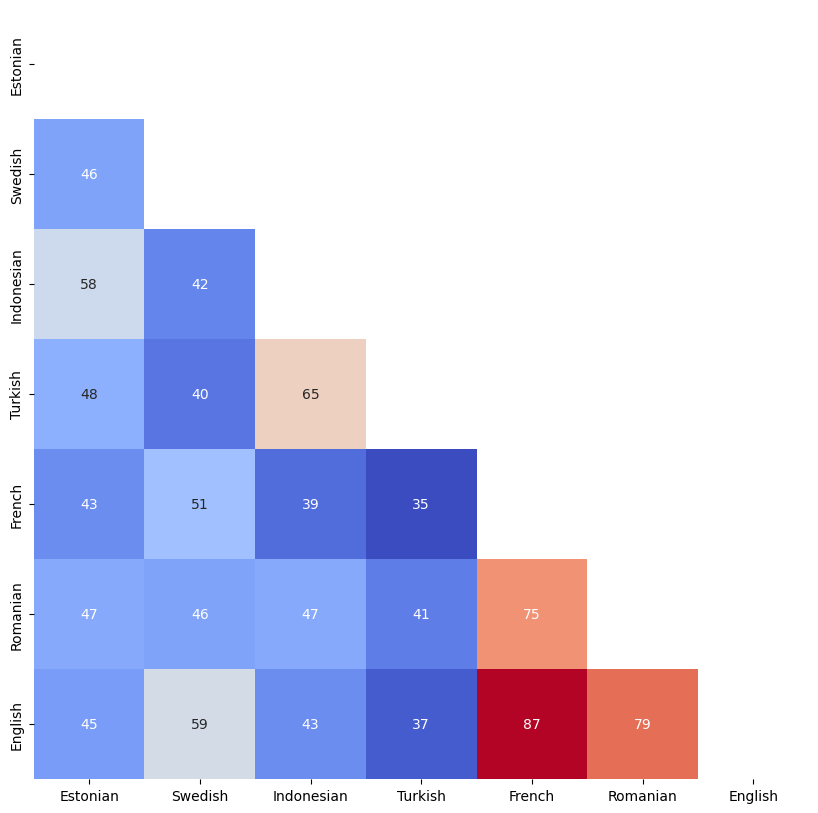

In [206]:
# Calculate number of shared trigrams
labels = lang
mat = []
for i in labels:
    vec = []
    for j in labels:
        l1 = features[i]
        l2 = features[j]
        intersec = [l for l in l1 if l in l2]
        # print(intersec)
        vec.append(len(intersec))
    mat.append(vec)

# Plot heatmap
conf_matrix_df = pd.DataFrame(mat, columns=lang, index=lang)
# Create a mask
mask = np.triu(np.ones_like(conf_matrix_df, dtype=bool))

plt.figure(figsize=(10, 10), facecolor="w", edgecolor="k")
# sns.set(font_scale=1.5)
sns.heatmap(
    conf_matrix_df,
    cmap="coolwarm",
    annot=True,
    fmt=".5g",
    cbar=False,
    mask=mask,
)

plt.savefig("./feat_explore.png", format="png", dpi=150)

In [207]:
# STEP 2: Write a Dataset class for creating the train and test datasets (and corresponding dataloaders).
#########


batch_size = 8

In [208]:
# https://discuss.pytorch.org/t/typeerror-batch-must-contain-tensors-numbers-dicts-or-lists-found-object/14665/3

# https://stackoverflow.com/questions/58612453/keyerror-when-enumerating-over-dataloader
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        thing = self.dataframe.iloc[index]

        t1 = thing.drop("lang").astype(np.float32)
        t1 = t1.tolist()
        t1 = torch.tensor(t1)

        t2 = thing["lang"].astype(np.int64)

        thing = [t1, t2]
        # print(thing)
        return thing

In [209]:
train_dataloader = DataLoader(
    PandasDataset(train_scaled), shuffle=True, batch_size=batch_size
)
val_dataloader = DataLoader(PandasDataset(val_scaled), batch_size=batch_size)

test_dataloader = DataLoader(
    PandasDataset(test_scaled), 
    #shuffle=True, 
    batch_size=batch_size
)

In [210]:
# STEP 3: Define the neural network model.
#########

# See: https://towardsdatascience.com/deep-neural-network-language-identification-ae1c158f6a7d

# loss='categorical_crossentropy',
# optimizer='adam',
# activation fns: relu x3, softmax x1

# lab3/lab3_mlp_classif.ipynb
# 237:    "However, when training a classification network, we generally use the [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) loss function, which alleviates these two issues. This loss is optimized for handling true labels instead of true probabilities per class, so you don't have to worry about it. Besides, it will automatically apply a [Softmax](https://pytorch.org/docs/stable/generated/torch.nn.Softmax.html) non-linearity to the predicted outputs, in order to normalize them as probabilities per class.\n",

# https://adamoudad.github.io/posts/keras_torch_comparison/syntax/


class ClassifModel(nn.Module):
    def __init__(
        self,
        input_size,
        output_size,
        hidden_size=20,
        act_fn=nn.ReLU(),
        n_hidden_layers=1,
    ):
        super(ClassifModel, self).__init__()

        self.input_layer = nn.Sequential(nn.Linear(input_size, hidden_size), act_fn)

        self.hiddens = nn.ModuleList([])
        for i in range(n_hidden_layers):
            self.hiddens.append(
                nn.Sequential(nn.Linear(hidden_size, hidden_size), act_fn)
            )

        alt_hidden_size = 30
        # This one is not in the hiddens loop because it has a different out_features size
        self.hidden2 = nn.Sequential(nn.Linear(hidden_size, alt_hidden_size), act_fn)

        # self.output_layer = nn.LazyLinear(output_size)
        self.output_layer = nn.Linear(alt_hidden_size, output_size)

        # NOTE: Unlike keras, we do not need a final softmax fn at the outputs,
        # because it's not necessary with torch.nn.CrossEntropyLoss.
        # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#
        # https://discuss.pytorch.org/t/do-i-need-to-use-softmax-before-nn-crossentropyloss/16739

    def forward(self, x):
        x = self.input_layer(x)

        if len(self.hiddens) != 0:
            for i, l in enumerate(self.hiddens):
                x = self.hiddens[i](x)

        x = self.hidden2(x)
        out = self.output_layer(x)
        return out


def test_model_definition():
    INPUT_SIZE = 663
    output_size = num_languages  # e.g. 7 or 22
    model = ClassifModel(INPUT_SIZE, output_size)
    return model


# test_model_definition()

In [211]:
# STEP 4: Define the hyperparameters to create an instance of the model
# (e.g., hidden space size, number of convolution kernels...)
# as well as the parameters required to train neural network (e.g., learning rate).
#########

# The Conor O'Sullivan article uses adam from Keras with default learning rate,
# and default there is 0.001: https://keras.io/api/optimizers/adam/
learning_rate = 0.001

# c.f. lab4.2
optimizer = torch.optim.Adam  # (model_tr.parameters(), lr=learning_rate)

In [239]:
# STEP 5: Write the training loop for training the model.
#########


def eval_mlp_classifier(model, eval_dataloader, loss_fn, confusionMatrix = False):
    """Evaluation function: similar to the training loop, except we don't need to compute any gradient / backprop.

    This function based on function from lab 4.1."""
    # Set the model in 'evaluation' mode (this disables some layers (batch norm, dropout...) which are not needed when testing)
    model.eval()
    # In evaluation phase, we don't need to compute gradients (for memory efficiency)
    with torch.no_grad():
        # initialize the total and correct number of labels to compute the accuracy
        correct_labels = 0
        total_labels = 0
        loss_eval = 0
        batch_count = 0
        lablesList = []
        predictionsList = []
        # Iterate over the dataset using the dataloader
        for images, labels in eval_dataloader:
            lablesList.extend(labels.tolist())
            batch_count += 1
            # Get the predicted labels
            y_predicted = model(images)

            # To get the predicted labels, we need to get the max over all possible classes
            _, label_predicted = torch.max(y_predicted.data, 1)

            loss = loss_fn(y_predicted, labels)
            # Record the loss
            loss_eval += loss.item()

            # Compute accuracy: count the total number of samples, and the correct labels (compare the true and predicted labels)
            total_labels += labels.size(0)
            correct_labels += (label_predicted == labels).sum().item()
            predictionsList.extend(label_predicted.tolist())

    if(confusionMatrix):
        labelsEncoding =  pd.Series(lablesList).drop_duplicates().tolist()
        cm = confusion_matrix(lablesList, predictionsList, labels=labelsEncoding)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot()
        plt.show()

    accuracy = 100 * correct_labels / total_labels
    return accuracy, loss_eval/batch_count


def plt_list_over_epochs(
    losses: list, evals: list,  num_epochs = 10
):
    
    plt.figure(figsize=(8,4))
    plt.subplot(1, 2, 1)
    plt.plot(torch.arange(num_epochs)+1, losses)
    plt.xlabel('Epochs')
    plt.title('Training')
    plt.subplot(1, 2, 2)
    plt.plot(torch.arange(num_epochs)+1, evals)
    plt.xlabel('Epochs')
    plt.title('Validation')
    plt.tight_layout()
    plt.show()

In [213]:
#######################
def train_val_classifier(
    model,
    train_dataloader,
    eval_dataloader,
    num_epochs,
    loss_fn,
    learning_rate,
    verbose=True,
):
    """Training function with validation.

    (Similar to lab 4.1 etc).
    - at the end of each epoch, compute the accuracy of the model on the validation subset using the provided evaluation function
    - then, check if this accuracy is increasing: if so, then we save the current model as the 'model_opt'.
    - return as output the trained model, the training loss, and the validation accuracy

    Important NOTE: if we compute the validation loss, it should decrease.
    If we compute accuracy, it should increase.
    """

    # Make a copy of the model (avoid changing the model outside this function)
    model_tr = copy.deepcopy(model)
    model = None  # for safety
    model_tr.train()  # Set the model in 'training' mode

    # Define the optimizer
    optimizer = torch.optim.Adam(
        model_tr.parameters(), lr=learning_rate
    )  # Hardcoded for now

    # Initialize a list to record the training loss over epochs
    loss_all_epochs = []
    altLossAllEpochs = []  # Alternate method, loss
    evalAllEpochsAcc = []  # list of validation metric (e.g. loss or accuracy)
    evalAllEpochsLoss = []
    # Training loop
    for epoch in range(num_epochs):
        # Initialize the training loss for the current epoch
        loss_current_epoch = 0
        altLCEs = []  # Alternate method

        # Iterate over batches using the dataloader
        for batch_index, (data, labels) in enumerate(train_dataloader):
            # training procedure for each batch...

            # Here we would vectorize if necessary (for example for images).
            vectorized_batch = data

            y = labels  # the prediction targets
            y_pred = model_tr(
                vectorized_batch
            )  # step1, forward pass (calculate predicted labels)

            l = loss_fn(y_pred, y)  # step2
            optimizer.zero_grad()
            l.backward()  # step3, compute the gradients
            optimizer.step()  # step4, (?apply gradient descent algorithm?)

            # update the loss at the current epoch
            loss_current_epoch += l.item()
            altLCEs.append(l.item())
            nBatchesThisEpoch = batch_index + 1

        # At the end of each epoch, record and display the loss over all batches
        loss_all_epochs.append(loss_current_epoch)

        altLossAvgThisEpoch = sum(altLCEs) / nBatchesThisEpoch
        altLossAllEpochs.append(altLossAvgThisEpoch)

        # at end of each epoch, compute the validation metric (e.g. accuracy, loss) of the model on validation subset
        eval_acc, eval_loss = eval_mlp_classifier(model_tr, eval_dataloader, loss_fn)
        evalAllEpochsAcc.append(eval_acc)
        evalAllEpochsLoss.append(eval_loss)

        if verbose:
            msg = "TRAINING Epoch [{}/{}], loss: {:.4f}, accuracy: {:.4f}"
            print(msg.format(epoch + 1, num_epochs, altLossAvgThisEpoch, eval_acc))

        # is eval metric improving? if so, then we save the current model as the 'model_opt'.
        if len(evalAllEpochsAcc) == 1:
            print("only one eval done yet")
            model_opt = model_tr
        elif (eval_acc >= max(evalAllEpochsAcc)) and (
            eval_acc not in evalAllEpochsAcc[:-1]
        ):
            # <= min() for "is LOSS DEcreasing", or >= max() for "is accuracy increasing"
            print("saving model from epoch {} as new model_opt".format(epoch + 1))
            model_opt = model_tr

    return model_opt, altLossAllEpochs, evalAllEpochsAcc, evalAllEpochsLoss

In [214]:
# STEP 6: Evaluate the model on the test data.
# In this part, it is expected to choose an appropriate evaluation metric based on your task.
# For instance, for classification task, accuracy should be computed (but you can also search for 'precision' and 'recall').
#########

# Execute the training (with validation)

LOSS_FN = torch.nn.CrossEntropyLoss
OPTIMIZER = torch.optim.Adam
# invoked as so: torch.optim.Adam(model_tr.parameters(), lr=learning_rate)
# currently this is hardcoded inside train_val_classifier()

if True:
    batch_size = 8
    num_epochs = 10
    loss_fn = LOSS_FN()

    train_dataloader = train_dataloader
    val_dataloader = val_dataloader

    input_size = num_trigram_features
    output_size = num_languages  # e.g. 7 or 22

    model = ClassifModel(input_size, output_size)

    
      # don't forget to instantiate() the loss fn
    learning_rate = learning_rate
    optimizer = OPTIMIZER

    trained_model, losses, evalsAcc, evalsLoss = train_val_classifier(
        model,
        train_dataloader,
        val_dataloader,
        num_epochs,
        loss_fn,
        learning_rate,
        verbose=True,
    )

TRAINING Epoch [1/10], loss: 0.4559, accuracy: 98.7143
only one eval done yet
TRAINING Epoch [2/10], loss: 0.0403, accuracy: 98.8571
saving model from epoch 2 as new model_opt
TRAINING Epoch [3/10], loss: 0.0198, accuracy: 99.0000
saving model from epoch 3 as new model_opt
TRAINING Epoch [4/10], loss: 0.0102, accuracy: 98.8571
TRAINING Epoch [5/10], loss: 0.0046, accuracy: 98.7143
TRAINING Epoch [6/10], loss: 0.0018, accuracy: 98.8571
TRAINING Epoch [7/10], loss: 0.0006, accuracy: 98.8571
TRAINING Epoch [8/10], loss: 0.0004, accuracy: 98.7143
TRAINING Epoch [9/10], loss: 0.0002, accuracy: 98.8571
TRAINING Epoch [10/10], loss: 0.0001, accuracy: 98.7143


In [215]:
# Finally, execute testing/eval also on the test data...
test_accuracy, test_loss  = eval_mlp_classifier(trained_model, test_dataloader, loss_fn)
print(f'{test_accuracy=}, {test_loss=}')

test_accuracy=97.85714285714286, test_loss=0.16844815619773754


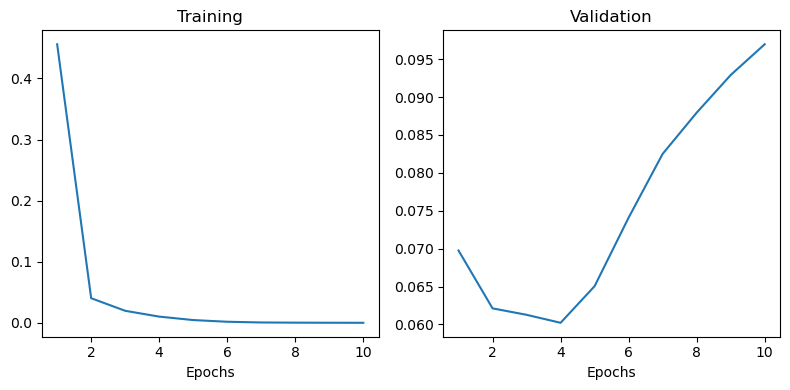

In [216]:
plt_list_over_epochs(losses, evalsLoss)

In [217]:
# STEP 7: Save the trained model parameters, and the obtained results if needed.
#########

DEFAULT_MODEL_SAVE_PATH = "lang_classifier.model.pt"
torch.save(trained_model.state_dict(), DEFAULT_MODEL_SAVE_PATH)

[2, 3, 1, 1, 0, 4, 3, 0, 4, 3, 5, 2, 1, 6, 3, 4, 4, 2, 0, 3, 3, 1, 4, 5, 0, 3, 4, 0, 0, 6, 6, 2, 3, 2, 5, 5, 5, 3, 6, 5, 2, 0, 1, 0, 4, 5, 2, 2, 4, 1, 1, 1, 3, 5, 6, 5, 4, 4, 3, 4, 3, 2, 5, 2, 0, 5, 0, 3, 0, 6, 3, 4, 2, 5, 2, 4, 3, 0, 2, 1, 2, 2, 5, 4, 5, 1, 0, 6, 0, 6, 4, 0, 2, 5, 1, 1, 2, 0, 2, 2, 3, 5, 0, 1, 2, 6, 1, 3, 2, 5, 3, 1, 0, 4, 4, 5, 6, 6, 0, 2, 1, 6, 2, 0, 4, 5, 5, 6, 1, 0, 2, 3, 5, 1, 5, 3, 0, 6, 5, 3, 3, 6, 3, 5, 1, 5, 3, 6, 1, 1, 0, 4, 1, 0, 1, 5, 4, 6, 3, 0, 2, 0, 1, 5, 3, 3, 0, 3, 3, 2, 5, 4, 3, 1, 3, 1, 1, 4, 6, 5, 2, 3, 2, 5, 5, 5, 3, 4, 0, 3, 5, 2, 3, 0, 6, 0, 3, 3, 6, 4, 2, 0, 6, 0, 5, 6, 2, 1, 6, 4, 4, 3, 3, 4, 6, 6, 0, 0, 6, 3, 1, 1, 6, 5, 6, 5, 0, 6, 0, 6, 3, 1, 4, 4, 3, 0, 6, 5, 4, 0, 5, 2, 3, 3, 6, 0, 1, 0, 5, 4, 5, 1, 1, 5, 5, 2, 3, 0, 1, 1, 5, 3, 6, 5, 6, 0, 0, 0, 6, 4, 0, 1, 1, 1, 0, 0, 6, 6, 3, 6, 3, 4, 0, 2, 1, 4, 5, 3, 2, 2, 5, 1, 5, 1, 2, 3, 0, 4, 2, 0, 3, 2, 0, 1, 4, 1, 3, 6, 4, 2, 5, 4, 1, 5, 4, 2, 5, 0, 6, 5, 6, 4, 4, 2, 2, 1, 4, 6, 5, 2, 4, 1, 2, 

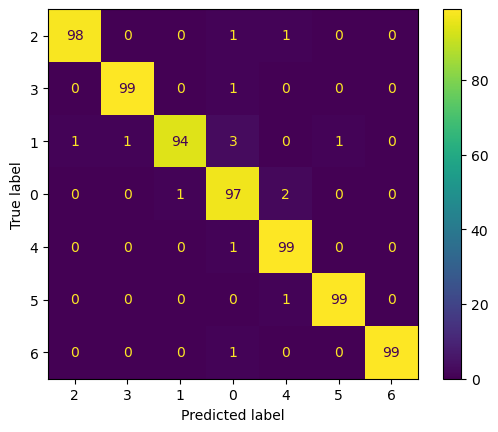

In [240]:
# TODO: (1) learning curve plots, (2) confusion matrix
test_accuracy, test_loss  = eval_mlp_classifier(trained_model, test_dataloader, loss_fn, True)




## Useful references

https://towardsdatascience.com/how-to-set-up-anaconda-and-jupyter-notebook-the-right-way-de3b7623ea4a  


Pandas piping function: https://verve.com/blog/jupyter-notebooks/


### 

https://stackoverflow.com/questions/20186344/importing-an-ipynb-file-from-another-ipynb-file  

https://jupyter-notebook.readthedocs.io/en/stable/examples/Notebook/Importing%20Notebooks.html  


###

https://stackoverflow.com/questions/50307707/how-do-i-convert-a-pandas-dataframe-to-a-pytorch-tensor

https://stackoverflow.com/questions/55724123/typeerror-cant-convert-np-ndarray-of-type-numpy-object

https://stackoverflow.com/questions/56741087/how-to-fix-runtimeerror-expected-object-of-scalar-type-float-but-got-scalar-typ

https://stackoverflow.com/questions/47488598/attributeerror-crossentropyloss-object-has-no-attribute-backward

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

https://lightrun.com/answers/biocore-ntnu-pyranges-deprecation-of-nplong-in-numpy-120-in-merge-method
